In [9]:
import numpy as np
import sdeint
import matplotlib.pyplot as plt
import math

# for plotting
from mpl_toolkits import mplot3d
import collections
import scipy.special as special



#Define constants
T = 1.0 #Temp
gamma = 20.0 #Viscosity
E_z = 10.0  #force .. ramped up from 0 to E_z
period = 10.0

B = np.sqrt(2*gamma*T)

num_sims = 1000; #number of simulations
t_f = 50.0; #simulation final time
dt = 0.01; #time step size
N = 1 + int(t_f/dt); #number of steps
ts = np.linspace(0, t_f+dt, N+1); #need the extra step for a reason...


# ramp of lamba from lambda_0 to lambda_f
lambda_0 = 0.1
lambda_f = E_z

t_ramp = 25.0; #transition time
Dt_ramp = 2.0; #transition time-scale

def ramp(z):
    "smooth ramp from 0 to 1"
    return 0.5*(1 + np.tanh(z))

def dramp(z):
    "smooth ramp from 0 to 1"
    return 0.5/(np.cosh(z)**2)

thetas = ramp((ts - t_ramp)/Dt_ramp)
dthetas = dramp((ts - t_ramp)/Dt_ramp)/Dt_ramp
lambda_s = lambda_0 + thetas*lambda_f
dlambda_s = dthetas*lambda_f
lambda_sin = 0.1+np.sin(2*np.pi/(period)*ts)
dlambda_sin = 2*np.pi/(period) * np.cos(2*np.pi/(period)*ts)


def f(x, v, lambda_):
    a = np.zeros(2)
    a[0] += -gamma*v[0]+np.cos(x[0])*np.sin(x[0])*(v[1]**2)                  # dissipation
    a[1] += -(gamma+2*np.cos(x[0])/(np.sin(x[0])+dt/5)*v[0])*v[1] 
    return a

def g(x, v, lambda_):
    b = np.zeros(2)
    b[0] += np.sqrt(dt)*B*np.random.normal()
    b[1] += np.sqrt(dt)*B*np.random.normal()
    return b

def force(x,lambda_):
    c = np.zeros(2)
    c[0] = -lambda_*np.sin(x[0])
    return c

#Now we need ese force
def counts(iterable, low, high, bins): #count the number of entries in a range for a given number of uniform bins
    step = (high - low + 0.0) / bins
    dist = collections.Counter((float(x) - low) // step for x in iterable)
    return [dist[b] for b in range(bins)]

#Initialize freq
num_bins= 100
freq_eq = np.zeros((num_bins,N+1)); # equilibrium
binspan = np.linspace(0, np.pi, num_bins)


for i in range(0,N+1):
    for j in range(0,num_bins):
        lambda_ = lambda_s[i]
        freq_eq[j,i] = np.exp((lambda_/T)*np.cos(binspan[j])) * np.sin(binspan[j])
    freq_eq[:,i] /= np.sum(freq_eq[:,i])

lmax = 10

dfreq_eq_dt = np.zeros((num_bins,N));
weighted = np.zeros((lmax,num_bins,N));
ese = np.zeros((lmax,N))


for l in range(0,lmax-1): #projection onto l+1st spherical harmonic
    for i in range(0,N):
        for j in range(0,num_bins):
            dfreq_eq_dt[j,i] = 1./dt*(freq_eq[j,i+1]-freq_eq[j,i])
            weighted[l,j,i]= -gamma*dfreq_eq_dt[j,i]*special.sph_harm(0,l+1,0,binspan[j])
        ese[l,i] = -1./((l+1)*(l+2))*sum(weighted[l,:,i])

ts = np.linspace(0, t_f, N); #now go back to regular number of times


def rho(x,lambda_):
    rho = 1./((4*np.pi*T*np.sinh(lambda_/T))/lambda_)*np.exp(lambda_*np.cos(x[0])/T)
    return rho

def f_ese(l,x,k,lambda_):
    f_ese = np.zeros(2)
    f_ese[0] = np.real(ese[l-1,k]*1/rho(x,lambda_)*np.sqrt(l*(l+1))*np.exp(-1j*x[1])*special.sph_harm(1,l,x[1],x[0]))
    return f_ese

def force_ese(x,k,lambda_):
    a = np.zeros(([lmax,2]))
    for i in range(1,lmax):
        a[i] = f_ese(i,x,k,lambda_)
    return sum(a[:])


def integrator(x0, v0):
    traj = (x0,)

    x = x0
    v = v0

    for k in range(N):
        t = ts[k]
        lambda_ = lambda_s[k]

        # --- (1) Propogate velocity ---
        v = v + dt*(f(x, v, lambda_)+force(x, lambda_)) + g(x, v, lambda_)  # ramping from lambda_0 to lambda_f
        # --- (2) Propogate position ---
        x = x + dt*v

        if x[0] < 0:
            x[0] = -x[0]
            x[1] = x[1]+np.pi
            v[0] = -v[0]
        elif x[0]>np.pi:
            x[0] = 2*np.pi-x[0]
            x[1] = x[1]-np.pi
            v[0] = -v[0]

        x[1] = math.atan2(np.sin(x[1]),np.cos(x[1]))

            # --- (3) record onto trajectory ---
        traj += (x,)


    return np.array(traj)



def integrator_ese(x0, v0):
    traj = (x0,)

    x = x0
    v = v0

    for k in range(N):
        t = ts[k]
        lambda_ = lambda_s[k]

        # --- (1) Propogate velocity ---
        v = v + dt*(f(x, v, lambda_)+force(x, lambda_)+f_ese(1,x,k,lambda_)+f_ese(2,x,k,lambda_)+f_ese(3,x,k,lambda_)+f_ese(4,x,k,lambda_)) + g(x, v, lambda_)  #+ ese2(x,lambda_,dlambda_) # ramping from lambda_0 to lambda_f
        # --- (2) Propogate position ---
        x = x + dt*v

        x[0] = math.atan2(np.sin(x[0]),np.cos(x[0]))

        if x[0] < 0:
            x[0] = -x[0]
            x[1] = x[1]+np.pi
            v[0] = -v[0]
        elif x[0]>np.pi:
            x[0] = 2*np.pi-x[0]
            x[1] = x[1]-np.pi
            v[0] = -v[0]

        x[1] = math.atan2(np.sin(x[1]),np.cos(x[1]))

            # --- (3) record onto trajectory ---
        traj += (x,)


    return np.array(traj)





# --- MAKES SIMULATIONS (finally!) ---
results = np.zeros([num_sims, N, 2])
results_ese = np.zeros([num_sims, N, 2])
inits = np.zeros([num_sims, 4])

for i in range(num_sims):
    print(i)
        # init position confined onto sphere
        # TODO: make rho_0 = rho_eq(t = 0)
    x0 = np.random.randn(2)
    x0[0] += 0.5*np.pi

        # init v0, with no radial component
    v0 = np.random.randn(2)


    traj = integrator(x0, v0)
    traj_ese = integrator_ese(x0, v0)

        # store results
    inits[i, :2] = x0
    inits[i, 2:] = v0
    results[i, :, :] = traj[1:, :]
    results_ese[i, :, :] = traj_ese[1:, :]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in cos
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in cos
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in add


31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in add


795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


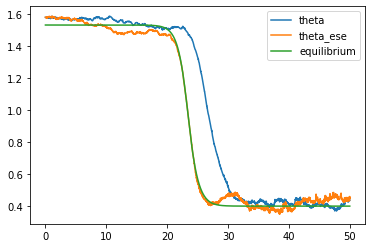

In [10]:
num_bins = 20; #number of bins in histogram
step_size = np.pi/num_bins; #size of bin

def counts(iterable, low, high, bins): #count the number of entries in a range for a given number of uniform bins
    step = (high - low + 0.0) / bins
    dist = collections.Counter((float(x) - low) // step for x in iterable)
    return [dist[b] for b in range(bins)]

#Initialize freq
freq = np.zeros((num_bins,N));
freq_ese = np.zeros((num_bins,N));
freq_eq = np.zeros((num_bins,N)); # equilibrium
rho_ese = np.zeros((num_bins,N));
rho_eq = np.zeros((num_bins,N)); # equilibrium
theta = np.zeros(N)
theta_ese = np.zeros(N)
theta_eq = np.zeros(N)

binspan = np.linspace(0, np.pi, num_bins)


#Fill freq: freq[j,i] is the fraction of simulations whose position at timestep i*dt is in the range -a+step_size*j < x < -a+step_size*(j+1)
for i in range(0,N):
    for j in range(0,num_bins):
        lambda_ = lambda_s[i]
        freq[j,i] = (1./num_sims)*counts(results[:,i,0], step_size*(j-.5), step_size*(j+0.5),1)[0]
        freq_ese[j,i] = (1./num_sims)*counts(results_ese[:,i,0], step_size*(j-.5), step_size*(j+0.5),1)[0]
        freq_eq[j,i] = np.exp((lambda_/T)*np.cos(binspan[j])) * np.sin(binspan[j])
    theta_eq[i] = 0.5*np.pi*(-np.exp(-lambda_/T)+special.iv(0,lambda_/T))/np.sinh(lambda_/T)
    freq_eq[:,i] /= np.sum(freq_eq[:,i])
    rho_eq[:,i] *= num_bins/np.pi*freq_eq[:,i]
    theta[i] = np.mean([x for x in results[:,i,0] if 0<x<np.pi])
    theta_ese[i] = np.mean([x for x in results_ese[:,i,0] if 0<x<np.pi])
    print(i)
    
#plt.contourf(ts,binspan,freq_eq);
#plt.colorbar();
#plt.ylabel('theta (radians)')
#plt.xlabel('time (a.u.)')
#plt.show()


#Create the plot
#plt.contourf(ts,binspan,freq);
#plt.colorbar();
#plt.ylabel('theta (radians)')
#plt.xlabel('time (a.u.)')
#plt.show()


plt.plot(ts,theta,label='theta')
plt.plot(ts,theta_ese, label='theta_ese')
plt.plot(ts,theta_eq, label='equilibrium')
plt.legend(loc = 'best')
plt.show()




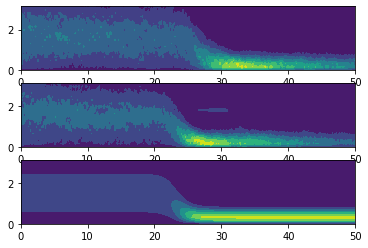

In [11]:
rho_eq = np.zeros((num_bins,N)); # equilibrium

rho_eq *= num_bins/np.pi*freq_eq
    
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.contourf(ts,binspan,freq)
ax2.contourf(ts,binspan,freq_ese)
ax3.contourf(ts,binspan,freq_eq)



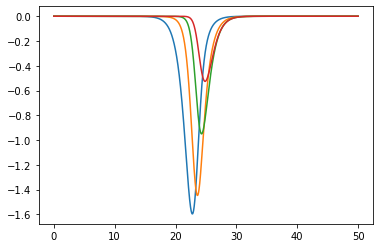

In [12]:
fese1 = np.zeros(N)
fese2 = np.zeros(N)
fese3 = np.zeros(N)
fese4 = np.zeros(N)

x=[0.5,0]
for i in range(0,N):
    lambda_ = lambda_s[i]
    fese1[i] = f_ese(1,x,i,lambda_)[0]
    fese2[i] = f_ese(2,x,i,lambda_)[0]
    fese3[i] = f_ese(3,x,i,lambda_)[0]
    fese4[i] = f_ese(4,x,i,lambda_)[0]
    

plt.plot(ts,fese1)
plt.plot(ts,fese2)
plt.plot(ts,fese3)
plt.plot(ts,fese4)
plt.show()

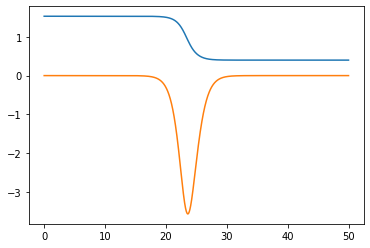

In [13]:
plt.plot(ts,theta_eq, label='equilibrium')
plt.plot(ts,fese1+fese2+fese3+fese4)
plt.show()

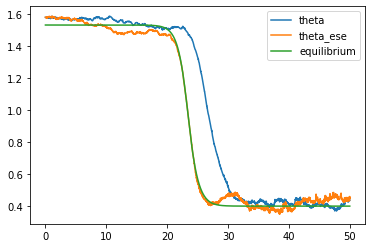

In [153]:
plt.plot(ts,theta,label='theta')
plt.plot(ts,theta_ese, label='theta_ese')
plt.plot(ts,theta_eq, label='equilibrium')
plt.legend(loc = 'best')
plt.show()

In [222]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

plt.figure(figsize=(10,10))

ax1 = plt.subplot(6,1,(1,3))
ax2 = plt.subplot(6,1,4, sharex=ax1)
ax3 = plt.subplot(6,1,5, sharex = ax1)
ax4 = plt.subplot(6,1,6, sharex = ax1)


ax1 = plt.subplot(6,1,(1,3), sharex = ax4)
ax1.plot(ts,theta,dashes=[7,7],label=r'$\langle\theta_{L}\rangle$')
ax1.plot(ts,theta_ese,dashes=[6,3],label=r'$\langle\theta_{ESE}\rangle$')
ax1.plot(ts,theta_eq, label=r'$\langle\theta_{eq}\rangle$')
ax1.legend(loc = [0.01,.75])
ax1.set_ylim(0,np.pi)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax5 = plt.axes([0,1,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.75,0.7,0.25,0.25])
ax5.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
ax5.plot(ts,lambda_s[:-1],color='C3')
ax5.text(0.5,1.20,r'$E(t)$',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax5.transAxes)

ax2.contourf(ts,binspan,freq)
ax3.contourf(ts,binspan,freq_ese)
ax4.contourf(ts,binspan,freq_eq)


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)


plt.savefig('sphere1.png')

ValueError: dashes sequence must have an even number of elements

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x114ae7598> (for post_execute):


ValueError: dashes sequence must have an even number of elements

ValueError: dashes sequence must have an even number of elements

<Figure size 720x720 with 5 Axes>

0.25

In [8]:
import numpy as np
import sdeint
import matplotlib.pyplot as plt
import math

# for plotting
from mpl_toolkits import mplot3d
import collections
import scipy.special as special



#Define constants
T = 1.0 #Temp
gamma = 20.0 #Viscosity
E_z = 10.0  #force .. ramped up from 0 to E_z
period = 6.0

B = np.sqrt(2*gamma*T)

num_sims = 5000; #number of simulations
t_f = 30.0; #simulation final time
dt = 0.01; #time step size
N = 1 + int(t_f/dt); #number of steps
ts = np.linspace(0, t_f+dt, N+1); #need the extra step for a reason...


# ramp of lamba from lambda_0 to lambda_f
lambda_0 = 0.1
lambda_f = E_z

t_ramp = 15.0; #transition time
Dt_ramp = 2.0; #transition time-scale

def ramp(z):
    "smooth ramp from 0 to 1"
    return 0.5*(1 + np.tanh(z))

def dramp(z):
    "smooth ramp from 0 to 1"
    return 0.5/(np.cosh(z)**2)

thetas = ramp((ts - t_ramp)/Dt_ramp)
dthetas = dramp((ts - t_ramp)/Dt_ramp)/Dt_ramp
lambda_s = lambda_0 + thetas*lambda_f
dlambda_s = dthetas*lambda_f
lambda_sin = 0.1+np.sin(2*np.pi/(period)*ts)
dlambda_sin = 2*np.pi/(period) * np.cos(2*np.pi/(period)*ts)


def f(x, v, lambda_):
    a = np.zeros(2)
    a[0] += -gamma*v[0]+np.cos(x[0])*np.sin(x[0])*(v[1]**2)                  # dissipation
    a[1] += -(gamma+2*np.cos(x[0])/(np.sin(x[0])+dt/5)*v[0])*v[1] # POTENTIAL TERM in z direction
    return a

def g(x, v, lambda_):
    b = np.zeros(2)
    b[0] += np.sqrt(dt)*B*np.random.normal()
    b[1] += np.sqrt(dt)*B*np.random.normal()
    return b

def force(x,lambda_):
    c = np.zeros(2)
    c[0] = -lambda_*np.sin(x[0])
    return c

#Now we need ese force
def counts(iterable, low, high, bins): #count the number of entries in a range for a given number of uniform bins
    step = (high - low + 0.0) / bins
    dist = collections.Counter((float(x) - low) // step for x in iterable)
    return [dist[b] for b in range(bins)]

#Initialize freq
num_bins= 100
freq_eq = np.zeros((num_bins,N+1)); # equilibrium
binspan = np.linspace(0, np.pi, num_bins)


for i in range(0,N+1):
    for j in range(0,num_bins):
        lambda_ = lambda_sin[i]
        freq_eq[j,i] = np.exp((lambda_/T)*np.cos(binspan[j])) * np.sin(binspan[j])
    freq_eq[:,i] /= np.sum(freq_eq[:,i])

lmax = 10

dfreq_eq_dt = np.zeros((num_bins,N));
weighted = np.zeros((lmax,num_bins,N));
ese = np.zeros((lmax,N))


for l in range(0,lmax-1): #projection onto l+1st spherical harmonic
    for i in range(0,N):
        for j in range(0,num_bins):
            dfreq_eq_dt[j,i] = 1./dt*(freq_eq[j,i+1]-freq_eq[j,i])
            weighted[l,j,i]= -gamma*dfreq_eq_dt[j,i]*special.sph_harm(0,l+1,0,binspan[j])
        ese[l,i] = -1./((l+1)*(l+2))*sum(weighted[l,:,i])

ts = np.linspace(0, t_f, N); #now go back to regular number of times


def rho(x,lambda_):
    rho = 1./((4*np.pi*T*np.sinh(lambda_/T))/lambda_)*np.exp(lambda_*np.cos(x[0])/T)
    return rho

def f_ese(l,x,k,lambda_):
    f_ese = np.zeros(2)
    f_ese[0] = np.real(ese[l-1,k]*1/rho(x,lambda_)*np.sqrt(l*(l+1))*np.exp(-1j*x[1])*special.sph_harm(1,l,x[1],x[0]))
    return f_ese

def force_ese(x,k,lambda_):
    a = np.zeros(([lmax,2]))
    for i in range(1,lmax):
        a[i] = f_ese(i,x,k,lambda_)
    return sum(a[:])

def integrator(x0, v0):
    traj = (x0,)

    x = x0
    v = v0

    for k in range(N):
        t = ts[k]
        lambda_ = lambda_sin[k]

        # --- (1) Propogate velocity ---
        v = v + dt*(f(x, v, lambda_)+force(x, lambda_)) + g(x, v, lambda_)  # ramping from lambda_0 to lambda_f
        # --- (2) Propogate position ---
        x = x + dt*v
        
        
        x[0] = math.atan2(np.sin(x[0]),np.cos(x[0]))
            
            
        if x[0] < 0:
            x[0] = -x[0]
            x[1] = x[1]+np.pi
            v[0] = -v[0]
        elif x[0]>np.pi:
            x[0] = 2*np.pi-x[0]
            x[1] = x[1]-np.pi
            v[0] = -v[0]

        x[1] = math.atan2(np.sin(x[1]),np.cos(x[1]))

            # --- (3) record onto trajectory ---
        traj += (x,)


    return np.array(traj)



def integrator_ese(x0, v0):
    traj = (x0,)

    x = x0
    v = v0

    for k in range(N):
        t = ts[k]
        lambda_ = lambda_sin[k]

        # --- (1) Propogate velocity ---
        v = v + dt*(f(x, v, lambda_)+force(x, lambda_)+f_ese(1,x,k,lambda_)+f_ese(2,x,k,lambda_)+f_ese(3,x,k,lambda_)+f_ese(4,x,k,lambda_)) + g(x, v, lambda_)  #+ ese2(x,lambda_,dlambda_) # ramping from lambda_0 to lambda_f
        # --- (2) Propogate position ---
        x = x + dt*v

        x[0] = math.atan2(np.sin(x[0]),np.cos(x[0]))

        if x[0] < 0:
            x[0] = -x[0]
            x[1] = x[1]+np.pi
            v[0] = -v[0]
        elif x[0]>np.pi:
            x[0] = 2*np.pi-x[0]
            x[1] = x[1]-np.pi
            v[0] = -v[0]

        x[1] = math.atan2(np.sin(x[1]),np.cos(x[1]))

            # --- (3) record onto trajectory ---
        traj += (x,)


    return np.array(traj)





# --- MAKES SIMULATIONS (finally!) ---
results = np.zeros([num_sims, N, 2])
results_ese = np.zeros([num_sims, N, 2])
inits = np.zeros([num_sims, 4])

for i in range(num_sims):
    print(i)
        # init position confined onto sphere
        # TODO: make rho_0 = rho_eq(t = 0)
    x0 = np.random.randn(2)
    x0[0] += 0.5*np.pi

        # init v0, with no radial component
    v0 = np.random.randn(2)


    traj = integrator(x0, v0)
    traj_ese = integrator_ese(x0, v0)

        # store results
    inits[i, :2] = x0
    inits[i, 2:] = v0
    results[i, :, :] = traj[1:, :]
    results_ese[i, :, :] = traj_ese[1:, :]




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in cos
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in cos


16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in cos
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in cos


157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in add


1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806


3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445


KeyboardInterrupt: 

In [ ]:
num_bins = 40; #number of bins in histogram
step_size = np.pi/num_bins; #size of bin

def counts(iterable, low, high, bins): #count the number of entries in a range for a given number of uniform bins
    step = (high - low + 0.0) / bins
    dist = collections.Counter((float(x) - low) // step for x in iterable)
    return [dist[b] for b in range(bins)]

#Initialize freq
freq = np.zeros((num_bins,N));
freq_ese = np.zeros((num_bins,N));
freq_eq = np.zeros((num_bins,N)); # equilibrium
theta = np.zeros(N)
theta_ese = np.zeros(N)
theta_eq = np.zeros(N)

binspan = np.linspace(0, np.pi, num_bins)
binspan_eq = np.linspace(0, np.pi, num_bins)


#Fill freq: freq[j,i] is the fraction of simulations whose position at timestep i*dt is in the range -a+step_size*j < x < -a+step_size*(j+1)
for i in range(0,N):
    for j in range(0,num_bins):
        lambda_ = lambda_sin[i]
        freq[j,i] = (1./num_sims)*counts(results[:,i,0], step_size*(j-.5), step_size*(j+0.5),1)[0]
        freq_ese[j,i] = (1./num_sims)*counts(results_ese[:,i,0], step_size*(j-.5), step_size*(j+0.5),1)[0]
        freq_eq[j,i] = np.exp((lambda_/T)*np.cos(binspan[j])) * np.sin(binspan[j])
    theta_eq[i] = 0.5*np.pi*(-np.exp(-lambda_/T)+special.iv(0,lambda_/T))/np.sinh(lambda_/T)
    freq_eq[:,i] /= np.sum(freq_eq[:,i])
    theta[i] = np.mean([x for x in results[:,i,0] if 0<x<np.pi])
    theta_ese[i] = np.mean([x for x in results_ese[:,i,0] if 0<x<np.pi])
    print(i)
    


In [ ]:
plt.plot(ts,theta,label='theta')
plt.plot(ts,theta_ese, label='theta_ese')
plt.plot(ts,theta_eq, label='equilibrium')
plt.legend(loc = 'best')
plt.show()




In [ ]:

rho_eq = np.zeros((num_bins,N)); # equilibrium

rho_eq *= num_bins/np.pi*freq_eq
    
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.contourf(ts,binspan,freq)
ax2.contourf(ts,binspan,freq_ese)
ax3.contourf(ts,binspan,freq_eq)
plt.show()

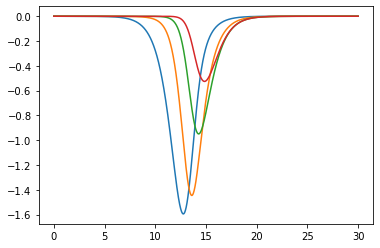

In [8]:
fese1 = np.zeros(N)
fese2 = np.zeros(N)
fese3 = np.zeros(N)
fese4 = np.zeros(N)

x=[0.5,0]
for i in range(0,N):
    lambda_ = lambda_s[i]
    fese1[i] = f_ese(1,x,i,lambda_)[0]
    fese2[i] = f_ese(2,x,i,lambda_)[0]
    fese3[i] = f_ese(3,x,i,lambda_)[0]
    fese4[i] = f_ese(4,x,i,lambda_)[0]
    

plt.plot(ts,fese1)
plt.plot(ts,fese2)
plt.plot(ts,fese3)
plt.plot(ts,fese4)
plt.show()

NameError: name 'lambda_0' is not defined

In [126]:
fese1table = np.zeros(N)
fese2table = np.zeros(N)
fese3table = np.zeros(N)
fese4table = np.zeros(N)
fese1direct = np.zeros(N)
fese2direct = np.zeros(N)

lambda_s = lambda_0 + 0.5*(1+np.tanh(2(ts-25.)))*lambda_f

x=[0.5,0]
for i in range(0,N):
    lambda_ = lambda_s[i]
    dlambda_ = dlambda_s[i]
    fese1table[i] = f_ese(1,x,i,lambda_)[0]
    fese2table[i] = f_ese(2,x,i,lambda_)[0]
    fese3table[i] = f_ese(3,x,i,lambda_)[0]
    fese4table[i] = f_ese(4,x,i,lambda_)[0]

plt.plot(fese1table)
plt.plot(fese2table)
plt.plot(fese3table)
plt.plot(fese4table)
plt.show()

TypeError: 'int' object is not callable